In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from zipfile import ZipFile
import skimage.io
from PIL import Image
import seaborn as sns
from sklearn.manifold import TSNE


from mnist_generator import get_mnist_loaders
from mnistm_generator import get_mnistm_loaders
from DANN import *
from DA import DenoisingAutoencoder
from test import *
from train import *
from visualize import *
from util import *

# make sure using CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# mnist dataset

In [4]:
mnist_train_loader,mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=64)

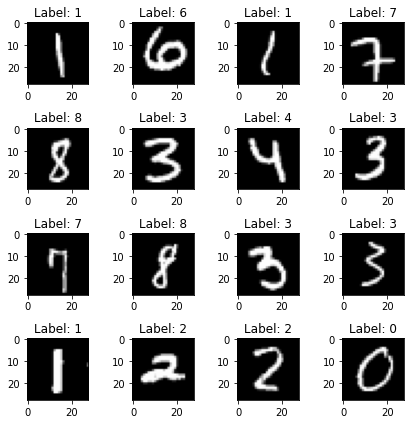

In [5]:

visualize_mnist(mnist_train_loader,4)

# mnistm dataset

In [6]:

mnistm_train_loader, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=64)

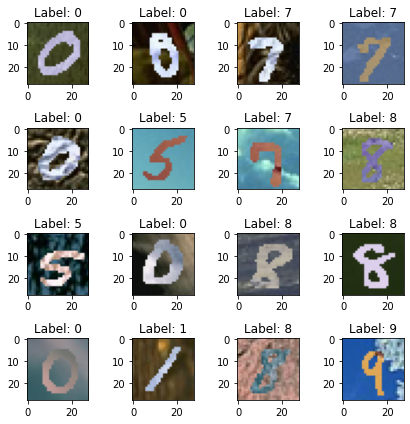

In [7]:
visualize_mnistm(mnistm_train_loader,4)

# visualization of representation of the original datasets

In [ ]:
features, labels = generate_domain_datas(mnist_train_loader, mnistm_train_loader)

In [ ]:
visualize_domain(features, labels, size=1000)

# source only

In [8]:
source_accs,dann_source_only = DANNTrain_source_only(mnist_train_loader, 
                                                                    mnist_eval_loader,
                                                                    epochs=10)

1/10: source_acc: 0.9126833333333333
2/10: source_acc: 0.9424333333333333
3/10: source_acc: 0.95235
4/10: source_acc: 0.9575833333333333
5/10: source_acc: 0.9607
6/10: source_acc: 0.9639833333333333
7/10: source_acc: 0.9659166666666666
8/10: source_acc: 0.9668
9/10: source_acc: 0.9685333333333334
10/10: source_acc: 0.9694833333333334


# target only

In [36]:
target_accs, dann_target_only = DANNTrain_source_only(mnistm_train_loader, mnistm_eval_loader, epochs=10)

1/10: source_acc: 0.6771666666666667
2/10: source_acc: 0.8112666666666667
3/10: source_acc: 0.8537666666666667
4/10: source_acc: 0.87435
5/10: source_acc: 0.8842333333333333
6/10: source_acc: 0.8915333333333333
7/10: source_acc: 0.8975833333333333
8/10: source_acc: 0.9011833333333333
9/10: source_acc: 0.9048833333333334
10/10: source_acc: 0.9090833333333334


# classifier only

In [8]:
def DANNTrain_classify_only(mnist_train,mnist_eval,mnistm_train,mnistm_eval,epochs):
    dann = DANN().to(device)

    criterion= nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(
        list(dann.parameters()),lr=0.01)
    source_accs = []
    target_accs = []
    total_steps = epochs* len(mnist_train)
    for epoch in range(epochs):
        start_steps = epoch * len(mnist_train)
        
        for batch_idx, (source, target) in enumerate(zip(mnist_train,mnistm_train)):
            source_image, source_label = source
            target_image, target_label = target

            p = float(batch_idx + start_steps)/ total_steps
            alpha = 2. / (1.+np.exp(-10*p))-1 

            source_image, source_label = source_image.to(device), source_label.to(device)
            target_image, target_label = target_image.to(device), target_label.to(device)
            # update learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01/(1.+10*p)**0.75

            # clear the grad
            optimizer.zero_grad()
            
            source_yp_labels, source_yp_domains = dann(source_image,alpha)
            target_yp_labels, target_yp_domains = dann(target_image,alpha)
            
            source_labels_loss = criterion(source_yp_labels, source_label)
            target_labels_loss = criterion(target_yp_labels, target_label)
            
            total_loss = source_labels_loss + target_labels_loss
            total_loss.backward()
            optimizer.step()

        with torch.no_grad():
            source_acc, target_acc  = DANNAccuracy_classify_only(dann, mnist_eval,mnistm_eval)
            source_accs.append(source_acc)
            target_accs.append(target_acc)
            print(f'{epoch+1}/{epochs}: source_acc: {source_acc}, target_acc {target_acc}')
    return source_accs, target_accs, dann

In [13]:
def DANNAccuracy_classify_only(dann, mnist_gen,mnistm_gen):
    s_cor = 0
    t_cor = 0
    for batch_idx,(source,target) in enumerate(zip(mnist_gen,mnistm_gen)):
        p = float(batch_idx)/len(mnist_gen)
        alpha = 2. / (1.+np.exp(-10*p))-1 
        source_image, source_label = source
        target_image, target_label = target
        source_image, source_label = source_image.to(device), source_label.to(device)
        target_image, target_label = target_image.to(device), target_label.to(device)
                
        source_yp_labels, source_yp_domains = dann(source_image,alpha)
        target_yp_labels, target_yp_domains = dann(target_image, alpha)
        source_yp_labels = source_yp_labels.data.max(1,keepdim=True)[1]
        target_yp_labels = target_yp_labels.data.max(1,keepdim=True)[1]
        s_cor += source_yp_labels.eq(source_label.data.view_as(source_yp_labels)).cpu().sum()
        t_cor += target_yp_labels.eq(target_label.data.view_as(target_yp_labels)).cpu().sum()
    s_acc = s_cor.item()/len(mnist_gen.dataset)
    t_acc = t_cor.item()/len(mnistm_gen.dataset)
    
    return s_acc, t_acc


In [15]:
source_accs, target_accs, dann_classify_only = DANNTrain_classify_only(mnist_train_loader,mnist_eval_loader,mnistm_train_loader, mnistm_eval_loader, epochs=30)

1/30: source_acc: 0.9380666666666667, target_acc 0.8331
2/30: source_acc: 0.9581833333333334, target_acc 0.8851
3/30: source_acc: 0.9650166666666666, target_acc 0.9030166666666667
4/30: source_acc: 0.9644833333333334, target_acc 0.9118166666666667
5/30: source_acc: 0.9712333333333333, target_acc 0.9211666666666667
6/30: source_acc: 0.9734, target_acc 0.9236666666666666
7/30: source_acc: 0.9741166666666666, target_acc 0.9272666666666667
8/30: source_acc: 0.97475, target_acc 0.92895
9/30: source_acc: 0.9753666666666667, target_acc 0.9315166666666667
10/30: source_acc: 0.97495, target_acc 0.9338166666666666
11/30: source_acc: 0.9777333333333333, target_acc 0.9375666666666667
12/30: source_acc: 0.9785166666666667, target_acc 0.9366833333333333
13/30: source_acc: 0.9793166666666666, target_acc 0.9382
14/30: source_acc: 0.9794833333333334, target_acc 0.9400666666666667
15/30: source_acc: 0.9798166666666667, target_acc 0.9416333333333333
16/30: source_acc: 0.98005, target_acc 0.94218333333333

# build DANN model

In [8]:
source_accs, target_accs, domain_accs, dann = DANNTrain(
      mnist_train_loader,
      mnistm_train_loader,
      mnist_eval_loader,
      mnistm_eval_loader,
      epochs=200)

1/200: source_acc: 0.9306,target_acc: 0.44133333333333336, domain_acc: 0.6196
2/200: source_acc: 0.9534166666666667,target_acc: 0.4755, domain_acc: 0.7088916666666667
3/200: source_acc: 0.9623166666666667,target_acc: 0.5404833333333333, domain_acc: 0.756575
4/200: source_acc: 0.96805,target_acc: 0.5486166666666666, domain_acc: 0.8108666666666666
5/200: source_acc: 0.9693833333333334,target_acc: 0.5633166666666667, domain_acc: 0.8091333333333334
6/200: source_acc: 0.9694,target_acc: 0.5823666666666667, domain_acc: 0.80175
7/200: source_acc: 0.97155,target_acc: 0.62215, domain_acc: 0.8090333333333334
8/200: source_acc: 0.9706333333333333,target_acc: 0.6556666666666666, domain_acc: 0.7953666666666667
9/200: source_acc: 0.9712833333333334,target_acc: 0.6930166666666666, domain_acc: 0.7867583333333333
10/200: source_acc: 0.9715666666666667,target_acc: 0.7250333333333333, domain_acc: 0.776075
11/200: source_acc: 0.96955,target_acc: 0.7388166666666667, domain_acc: 0.7632416666666667
12/200: s

92/200: source_acc: 0.9716333333333333,target_acc: 0.91445, domain_acc: 0.57955
93/200: source_acc: 0.9772166666666666,target_acc: 0.9118666666666667, domain_acc: 0.5853583333333333
94/200: source_acc: 0.9761,target_acc: 0.90795, domain_acc: 0.5880666666666666
95/200: source_acc: 0.97615,target_acc: 0.9037666666666667, domain_acc: 0.5979583333333334
96/200: source_acc: 0.9771166666666666,target_acc: 0.9087166666666666, domain_acc: 0.594225
97/200: source_acc: 0.9741166666666666,target_acc: 0.9112, domain_acc: 0.5721
98/200: source_acc: 0.9754166666666667,target_acc: 0.9148166666666666, domain_acc: 0.5760333333333333
99/200: source_acc: 0.97785,target_acc: 0.9131666666666667, domain_acc: 0.5799666666666666
100/200: source_acc: 0.97395,target_acc: 0.91085, domain_acc: 0.57745
101/200: source_acc: 0.9788,target_acc: 0.9104333333333333, domain_acc: 0.5917333333333333
102/200: source_acc: 0.9786333333333334,target_acc: 0.9142, domain_acc: 0.5917916666666667
103/200: source_acc: 0.97525,targ

181/200: source_acc: 0.9825166666666667,target_acc: 0.92215, domain_acc: 0.5832333333333334
182/200: source_acc: 0.9805333333333334,target_acc: 0.9179666666666667, domain_acc: 0.5924666666666667
183/200: source_acc: 0.98175,target_acc: 0.9182833333333333, domain_acc: 0.5907666666666667
184/200: source_acc: 0.9804666666666667,target_acc: 0.9161166666666667, domain_acc: 0.5751833333333334
185/200: source_acc: 0.9811166666666666,target_acc: 0.9216833333333333, domain_acc: 0.5751666666666667
186/200: source_acc: 0.9828333333333333,target_acc: 0.9204666666666667, domain_acc: 0.5891416666666667
187/200: source_acc: 0.9813333333333333,target_acc: 0.9238166666666666, domain_acc: 0.5758666666666666
188/200: source_acc: 0.979,target_acc: 0.9210333333333334, domain_acc: 0.5723333333333334
189/200: source_acc: 0.98135,target_acc: 0.921, domain_acc: 0.5853333333333334
190/200: source_acc: 0.9815333333333334,target_acc: 0.9203833333333333, domain_acc: 0.5858833333333333
191/200: source_acc: 0.980883

In [11]:
# USE WHEN YOU WANT TO LOAD THE SAVED MODEL
# dann = load_DANN("./models/dann_v1.pt")

In [9]:
s_acc, t_acc, domain_acc = DANNAccuracy(dann, mnist_test_loader,mnistm_test_loader)
print(f'source_acc: {s_acc},target_acc: {t_acc}, domain_acc: {domain_acc}')

source_acc: 0.9754,target_acc: 0.924, domain_acc: 0.5801


In [10]:
features, labels = generate_domain_datas_from_dann(dann, mnist_train_loader,mnistm_train_loader)

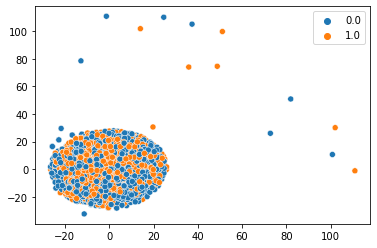

In [11]:
visualize_domain_tSNE(features, labels,size=10000)

In [12]:
# USE WHEN YOU WANT TO SAVE OR UPDATE THE MODEL
# save_model(dann,"./models/dann_v1.pt")

# Denoising Autoencoders

In [22]:
loss_arr, autoencoder = DATrain(mnist_train_loader, mnistm_train_loader, mnist_eval_loader, mnistm_eval_loader,1000,100)

1/100: avg_loss:0.0668058693408966
2/100: avg_loss:0.059615883976221085
3/100: avg_loss:0.054485224187374115
4/100: avg_loss:0.0502043217420578
5/100: avg_loss:0.04574410244822502
6/100: avg_loss:0.04012218117713928
7/100: avg_loss:0.031964510679244995
8/100: avg_loss:0.02867470309138298
9/100: avg_loss:0.026261068880558014
10/100: avg_loss:0.02459455095231533
11/100: avg_loss:0.02343723177909851
12/100: avg_loss:0.02217070572078228
13/100: avg_loss:0.021294401958584785
14/100: avg_loss:0.02045038901269436
15/100: avg_loss:0.019770102575421333
16/100: avg_loss:0.0191221684217453
17/100: avg_loss:0.018374811857938766
18/100: avg_loss:0.017588578164577484
19/100: avg_loss:0.016649195924401283
20/100: avg_loss:0.016204459592700005
21/100: avg_loss:0.015529153868556023
22/100: avg_loss:0.015107300132513046
23/100: avg_loss:0.014990142546594143
24/100: avg_loss:0.01485123299062252
25/100: avg_loss:0.014631038531661034
26/100: avg_loss:0.014467750675976276
27/100: avg_loss:0.0144678521901369

In [49]:
def visualize_from_DA_temp(autoencoder,loader,size):
    temp_iter = iter(loader)
    temp_features, temp_labels = temp_iter.next()
    temp_features = temp_features.expand(temp_features.data.shape[0],3,28,28)
    compressed_features = autoencoder.encoder(temp_features.to(device)).cpu().detach()
    compressed_features = (compressed_features - compressed_features.min())*(1/(compressed_features.max()-compressed_features.min()))
    fig, axes = plt.subplots(size,size, figsize=(1.5*size,1.5*size))
    for i in range(size):
        for j in range(size):
            axes[i,j].imshow((compressed_features[i*4+j].transpose(0,2).transpose(0,1)).type(torch.float))
            axes[i,j].set_title(f"Label: {temp_labels[i*4+j]}")
    plt.tight_layout()
    plt.show()

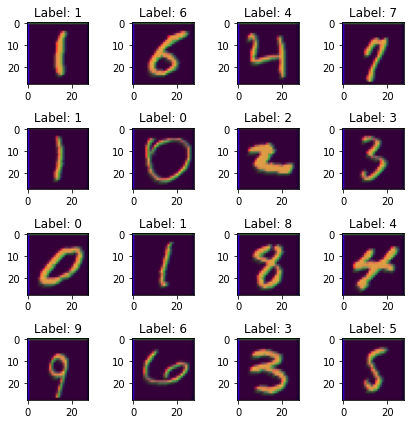

In [50]:
visualize_from_DA_temp(autoencoder,mnist_train_loader,4)

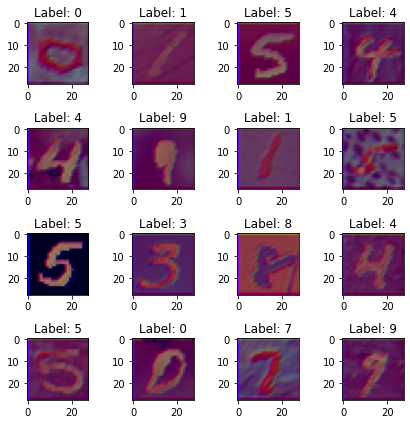

In [51]:
visualize_from_DA_temp(autoencoder,mnistm_train_loader,4)

In [28]:
save_model(autoencoder,"./models/da_v1.pt")

In [13]:
autoencoder = DenoisingAutoencoder(100)
autoencoder = load_DA("./models/da_v1.pt")

In [14]:
def generate_domain_datas_DA(dann,autoencoder, mnist_gen,mnistm_gen):
    with torch.no_grad():
        total_x = torch.tensor([])
        total_y = torch.tensor([])
        for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
            source_image, source_label = source
            target_image, target_label = target

            # the source is 1 * 28 * 28, we have to preprocess it
            #source_image = torch.cat((source_image, source_image, source_image),1)

            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                        torch.ones(target_label.size()[0]).type(torch.LongTensor)),0)
            source = source_image.expand(source_image.data.shape[0],3,28,28)
            source = autoencoder.encoder(source.to(device))
            source = (source - source.min())*(1/(source.max()-source.min()))
            #source = dann.extractor(source.to(device))
            source = source.view(-1,3*28*28).cpu()
            target = target_image.expand(target_image.data.shape[0],3,28,28)
            target = autoencoder.encoder(target.to(device))
            target = (target - target.min())*(1/(target.max()-target.min()))
            #target = dann.extractor(target.to(device))
            target = target.view(-1,3*28*28).cpu()
            temp = torch.cat((source,target),0)
            total_x = torch.cat((total_x,temp),0)
            total_y = torch.cat((total_y,domain_label),0)
    return total_x, total_y

In [15]:
features, labels = generate_domain_datas_DA(dann,autoencoder, mnist_train_loader,mnistm_train_loader)

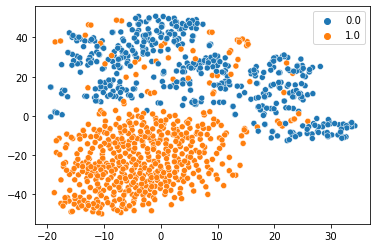

In [16]:
visualize_domain_tSNE(features, labels,size=1000)

# DANN with encoder from autoencoder

In [60]:
def DANNAccuracy_with_DA(dann,autoencoder, mnist_gen, mnistm_gen):
    s_cor = 0
    t_cor = 0
    domain_cor = 0
    for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
        p = float(batch_idx)/len(mnist_gen)
        alpha = 2. / (1.+np.exp(-10*p))-1 
        source_image, source_label = source
        target_image, target_label = target
        
        source_image, source_label = source_image.to(device), source_label.to(device)
        target_image, target_label = target_image.to(device), target_label.to(device)
        
        source_image = source_image.expand(source_image.data.shape[0],3,28,28)
            
        source_image = autoencoder.encoder(source_image)
        target_image = autoencoder.encoder(target_image)
                
        source_yp_labels, source_yp_domains = dann(source_image,alpha)
        target_yp_labels, target_yp_domains = dann(target_image, alpha)
        
        source_yp_labels = source_yp_labels.data.max(1,keepdim=True)[1]
        s_cor += source_yp_labels.eq(source_label.data.view_as(source_yp_labels)).cpu().sum()
        
        target_yp_labels = target_yp_labels.data.max(1,keepdim=True)[1]
        t_cor += target_yp_labels.eq(target_label.data.view_as(target_yp_labels)).cpu().sum()
        
        source_y_domains = torch.zeros(source_label.size()[0]).type(torch.LongTensor).to(device)
        target_y_domains =  torch.ones(target_label.size()[0]).type(torch.LongTensor).to(device)
        
        source_yp_domains = source_yp_domains.data.max(1,keepdim=True)[1]
        domain_cor += source_yp_domains.eq(source_y_domains.data.view_as(source_yp_domains)).cpu().sum()
        target_yp_domains = target_yp_domains.data.max(1,keepdim=True)[1]
        domain_cor += target_yp_domains.eq(target_y_domains.data.view_as(target_yp_domains)).cpu().sum()

    domain_acc = domain_cor.item()/(len(mnist_gen.dataset)+len(mnistm_gen.dataset))
    s_acc = s_cor.item()/len(mnist_gen.dataset)
    t_acc = t_cor.item()/len(mnistm_gen.dataset)
    
    return s_acc, t_acc, domain_acc

In [63]:
def DANNTrain_with_DA(autoencoder,mnist_train, mnistm_train, mnist_eval, mnistm_eval, epochs):
    dann = DANN().to(device)

    criterion= nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(
        list(dann.parameters()),lr=0.01)
    domain_accs =[]
    source_accs = []
    target_accs = []
    total_steps = epochs* len(mnistm_train)
    for epoch in range(epochs):
        start_steps = epoch * len(mnist_train)
        
        for batch_idx, (source, target) in enumerate(zip(mnist_train, mnistm_train)):
            source_image, source_label = source
            target_image, target_label = target

            p = float(batch_idx + start_steps)/ total_steps
            alpha = 2. / (1.+np.exp(-10*p))-1 

            source_image, source_label = source_image.to(device), source_label.to(device)
            target_image, target_label = target_image.to(device), target_label.to(device)

            # update learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01/(1.+10*p)**0.75

            # clear the grad
            optimizer.zero_grad()
            source_image = source_image.expand(source_image.data.shape[0],3,28,28)
            
            source_image = autoencoder.encoder(source_image)
            target_image = autoencoder.encoder(target_image)
            source_image = (source_image - source_image.min())*(1/(source_image.max()-source_image.min()))
            target_image = (target_image - target_image.min())*(1/(target_image.max()-target_image.min()))
            
            source_yp_labels, source_yp_domains = dann(source_image,alpha)
            target_yp_labels, target_yp_domains = dann(target_image,alpha)

            
            source_labels_loss = criterion(source_yp_labels, source_label)
            source_domain_loss = criterion(source_yp_domains, torch.zeros(source_label.size()[0]).type(torch.LongTensor).to(device))
            target_domain_loss = criterion(target_yp_domains, torch.ones(target_label.size()[0]).type(torch.LongTensor).to(device))
            
            total_loss = source_labels_loss + source_domain_loss + target_domain_loss
            total_loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                source_acc, target_acc, domain_acc = DANNAccuracy_with_DA(dann, autoencoder,mnist_eval, mnistm_eval)
                domain_accs.append(domain_acc)
                source_accs.append(source_acc)
                target_accs.append(target_acc)
                print(f'{epoch+1}/{epochs}: source_acc: {source_acc},target_acc: {target_acc}, domain_acc: {domain_acc}')
    return source_accs, target_accs, domain_accs, dann

In [64]:
source_accs, target_accs, domain_accs, dann=DANNTrain_with_DA(autoencoder, 
                                                                                mnist_train_loader, 
                                                                                mnistm_train_loader, 
                                                                                mnist_eval_loader, 
                                                                                mnistm_eval_loader, 
                                                                                100)

10/100: source_acc: 0.9626166666666667,target_acc: 0.7547833333333334, domain_acc: 0.6987333333333333
20/100: source_acc: 0.9621166666666666,target_acc: 0.8462666666666666, domain_acc: 0.6283916666666667
30/100: source_acc: 0.9638,target_acc: 0.8696166666666667, domain_acc: 0.6012166666666666
40/100: source_acc: 0.9691833333333333,target_acc: 0.8727166666666667, domain_acc: 0.5980416666666667
50/100: source_acc: 0.9679666666666666,target_acc: 0.87985, domain_acc: 0.578525
60/100: source_acc: 0.9745333333333334,target_acc: 0.8840666666666667, domain_acc: 0.5858416666666667
70/100: source_acc: 0.97295,target_acc: 0.8839166666666667, domain_acc: 0.57755
80/100: source_acc: 0.9750833333333333,target_acc: 0.8893, domain_acc: 0.5820666666666666
90/100: source_acc: 0.9764666666666667,target_acc: 0.88365, domain_acc: 0.58675
100/100: source_acc: 0.9745,target_acc: 0.8893, domain_acc: 0.5785083333333333


In [65]:
save_model(dann, "./models/dann_da_v1.pt")

In [66]:
DANNAccuracy_with_DA(dann,autoencoder, mnist_test_loader, mnistm_test_loader)

(0.969, 0.8929, 0.58045)

In [34]:
def generate_domain_datas_from_extractor_with_DA(dann,autoencoder, mnist_gen,mnistm_gen):
    with torch.no_grad():
        total_x = torch.tensor([])
        total_y = torch.tensor([])
        for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
            source_image, source_label = source
            target_image, target_label = target

            # the source is 1 * 28 * 28, we have to preprocess it
            #source_image = torch.cat((source_image, source_image, source_image),1)

            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                        torch.ones(target_label.size()[0]).type(torch.LongTensor)),0)
            source = source_image.expand(source_image.data.shape[0],3,28,28)
            source = autoencoder.encoder(source.to(device))
            source = dann.extractor(source.to(device))
            source = source.view(-1,64*4*4).cpu()
            target = target_image.expand(target_image.data.shape[0],3,28,28)
            target = autoencoder.encoder(target.to(device))
            target = dann.extractor(target.to(device))
            target = target.view(-1,64*4*4).cpu()
            temp = torch.cat((source,target),0)
            total_x = torch.cat((total_x,temp),0)
            total_y = torch.cat((total_y,domain_label),0)
    return total_x, total_y

In [35]:
features, labels = generate_domain_datas_from_extractor_with_DA(dann,autoencoder, mnist_train_loader,mnistm_train_loader)

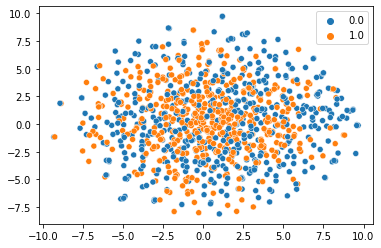

In [36]:
visualize_domain_tSNE(features, labels,size=1000)

# Proxy A-distance